# Plots to visualize b9d2 pheontypes for labmeeting 

## Setup: Configure Environment and Import Functions

In [1]:
import os

os.chdir(os.environ['MORPHSEQ_REPO_ROOT']) 

import pandas as pd

# Import MD-DTW analysis tools
from src.analyze.trajectory_analysis import (
    # Step 2: Array preparation
    prepare_multivariate_array,


    # Step 3: Distance computation
    compute_md_dtw_distance_matrix,

    # Step 4: Outlier detection
    identify_outliers,
    remove_outliers_from_distance_matrix,

    # Step 5: Clustering & visualization (NEW API)
    generate_dendrograms,
    add_cluster_column,
    run_bootstrap_hierarchical,
    analyze_bootstrap_results,
    plot_multimetric_trajectories,
    plot_trajectories_faceted,
    PASTEL_COLORS,

    # K-SELECTION PIPELINE (Phase 1) - SEPARATE FUNCTIONS for granular control
    evaluate_k_range,              # Evaluate multiple k values with metrics
    plot_k_selection,              # Visualize k comparison across all metrics
    classify_membership_2d,        # Core/uncertain/outlier classification

    # Consensus clustering (Phase 2)
    run_consensus_pipeline,        # Full two-stage pipeline
)

from src.analyze.trajectory_analysis.facetted_plotting import plot_proportion_grid
from src.analyze.trajectory_analysis.facetted_plotting import plot_proportion_faceted

# Re-import with new K-medoids functionality
from src.analyze.trajectory_analysis import (
    run_k_selection_with_plots,
    run_bootstrap_kmedoids,
    run_bootstrap_hierarchical,
)

# Import add_membership_column from k_selection module directly
from src.analyze.trajectory_analysis.k_selection import add_membership_column

from src.analyze.trajectory_analysis import plot_dendrogram_with_categories

# For loading data
from src.analyze.trajectory_analysis import extract_trajectories_df

from src.analyze.trajectory_analysis import compute_trajectory_distances

from pathlib import Path
results_dir = "results/mcolon/20251219_b9d2_phenotype_extraction"
plot_dir = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20251219_b9d2_phenotype_extraction/plots")
plot_dir.mkdir(parents=True, exist_ok=True)

print("✓ Imports successful!")

✓ Imports successful!


## Step 1: Load and Filter Data

Load your trajectory data as a long-format DataFrame with columns:
- `embryo_id`: Unique identifier for each embryo
- `predicted_stage_hpf`: Time in hours post fertilization
- Metric columns (e.g., `baseline_deviation_normalized`, `total_length_um`, etc.)
- Optional: `genotype`, `pair`, or other categorical columns for visualization

In [2]:
# Example: Load your data
# Replace this with your actual data loading code

# Option 1: Load from CSV
import pandas as pd

# Load the labeled b9d2 data
df = pd.read_csv('results/mcolon/20251219_b9d2_phenotype_extraction/data/b9d2_labeled_data.csv')

# Display basic info
print(f"Loaded {len(df):,} rows, {df['embryo_id'].nunique()} unique embryos")
print(f"\nColumns: {df.shape[1]}")
print(f"\nCluster categories:")
print(df.groupby('cluster_categories')['embryo_id'].nunique().sort_values(ascending=False))
print(f"\nFirst few rows:")
df.head()

#Option 2: Use existing data loading utilities

# from src.analyze.trajectory_analysis.data_loading import load_experiment_dataframe
# # List all experiments you want to analyze together
# experiment_ids = ['20250512','20251017_combined','20251106', '20251112', '20251113', '20251205','20251212']  # Add your experiment IDs

# # Load and combine
# dfs = []
# for exp_id in experiment_ids:
#     df_exp = load_experiment_dataframe(exp_id, format_version='df03')
#     df_exp['experiment_id'] = exp_id  # Track which experiment each row came from
#     dfs.append(df_exp)
#     print(f"✓ Loaded {exp_id}: {len(df_exp)} rows, {df_exp['embryo_id'].nunique()} embryos")

# # Concatenate all experiments
# df = pd.concat(dfs, ignore_index=True)

# print(f"\n✓ Combined data: {len(df)} rows, {df['embryo_id'].nunique()} embryos")
# print(f"  Experiments: {df['experiment_id'].unique()}")

# df = df.loc[df["genotype"].str.contains("cep290", na=False)]

# df.loc[df["pair"].isna(), "pair"] = "cep290_spawn"

# df["pair"].value_counts(dropna=False)



Loaded 23,074 rows, 187 unique embryos

Columns: 298

Cluster categories:
cluster_categories
unlabeled    83
CE           38
wildtype     35
HTA          24
BA_rescue     7
Name: embryo_id, dtype: int64

First few rows:


,snip_id,total_length_um,mean_curvature_per_um,std_curvature_per_um,max_curvature_per_um,n_centerline_points,baseline_deviation_um,max_baseline_deviation_um,baseline_deviation_std_um,arc_length_ratio,...,z_sigma_b_91,z_sigma_b_92,z_sigma_b_93,z_sigma_b_94,z_sigma_b_95,z_sigma_b_96,z_sigma_b_97,z_sigma_b_98,z_sigma_b_99,cluster_categories
0,20251121_A01_e01_t0000,1768.112822,0.002667,0.002473,0.014522,200,145.614123,306.658990,105.421123,1.098773,...,0.007566,0.023436,0.018847,-0.006451,0.024283,-0.027873,-0.025036,0.024789,0.015468,unlabeled
1,20251121_A01_e01_t0025,2462.752310,0.000375,0.000645,0.002997,200,10.148831,21.042284,6.945754,1.001935,...,-0.027657,0.001076,-0.009712,-0.007351,0.025272,-0.013310,0.028793,0.016563,0.004174,unlabeled
2,20251121_A01_e01_t0026,2462.051152,0.000311,0.000483,0.002535,200,14.697168,24.898420,7.402503,1.001433,...,-0.028383,0.003783,-0.013360,-0.001477,0.030024,-0.016675,0.026122,0.024184,-0.002831,unlabeled
3,20251121_A01_e01_t0027,2505.253328,0.000251,0.000364,0.002009,200,25.028206,39.121608,10.511048,1.001429,...,-0.026466,0.004764,0.000409,0.007882,0.029257,-0.007548,0.021775,0.032981,-0.012858,unlabeled
4,20251121_A01_e01_t0028,2527.971734,0.000255,0.000367,0.002072,200,34.365740,47.366541,12.829600,1.001999,...,-0.030107,0.006094,0.002285,-0.000659,0.031287,-0.005718,0.015834,0.029787,-0.017300,unlabeled


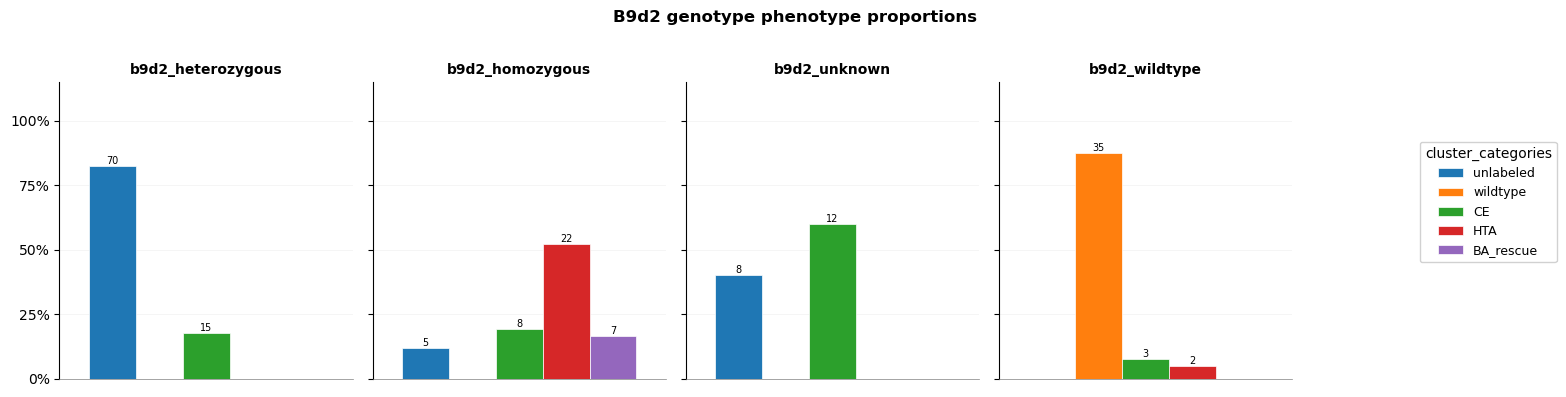

In [5]:

fig_proportion_grid = plot_proportion_faceted(
    df,
    color_by_grouping= "cluster_categories",
    # color_palette=PHENOTYPE_PALETTE,
    row_by= None,
    col_by= "genotype",
    count_by= 'embryo_id',
    # output_path = plot_dir / 'cep290_pairs_swap_homozygous_only_proportion_grid_by_curvature_phenotype_trend.png',
    title = "B9d2 genotype phenotype proportions"
)

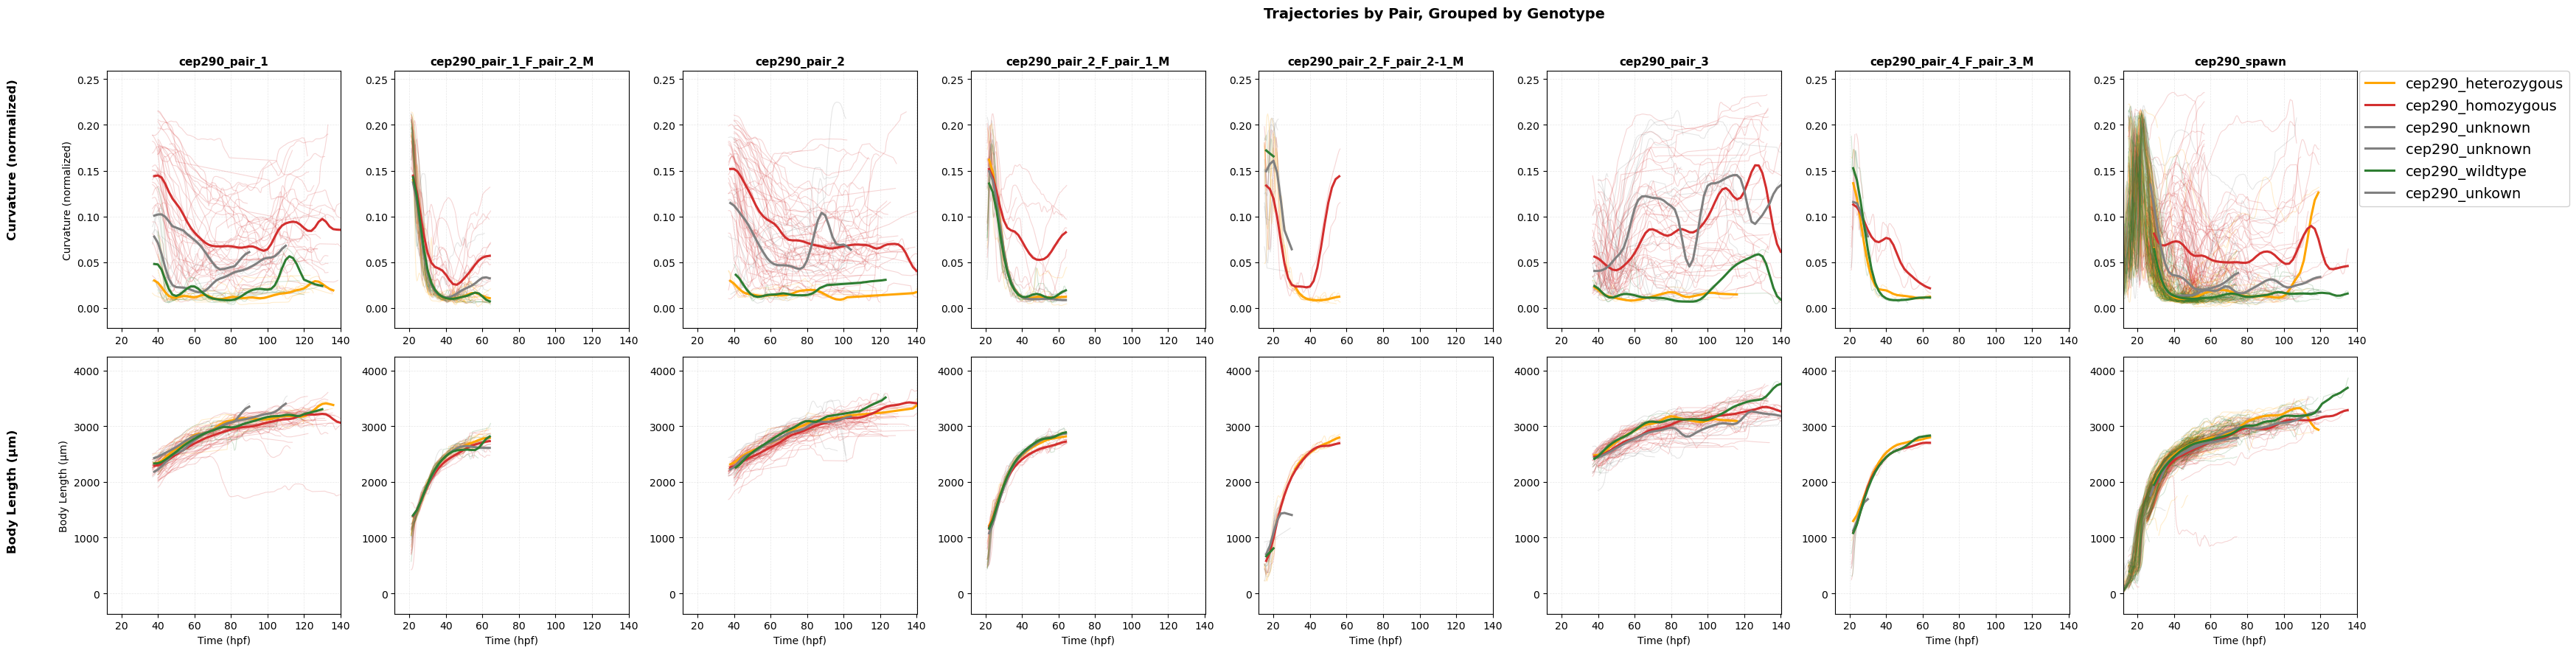

In [4]:
plot_dir = Path('results/mcolon/20251229_cep290_phenotype_extraction/general_plots')
plot_dir.mkdir(parents=True, exist_ok=True)
    # Optional: Color by genotype instead to validate clusters separate genotypes
    
fig_by_genotype = plot_multimetric_trajectories(
        df,
        metrics=['baseline_deviation_normalized', 'total_length_um'],
        col_by='pair',
        color_by_grouping='genotype',  # NEW API: groups AND colors by genotype
        x_col='predicted_stage_hpf',
        metric_labels={
            'baseline_deviation_normalized': 'Curvature (normalized)',
            'total_length_um': 'Body Length (μm)',
        },
        title='Trajectories by Pair, Grouped by Genotype',
        x_label='Time (hpf)',
        backend='both',
        bin_width=2.0,
        output_path=plot_dir / 'cep290_trajectories_by_pair_grouped_by_genotype.png'
    )

